<a href="https://colab.research.google.com/github/camilodlt/rtidy-python/blob/main/REGRESSION/JULIA_MLJ/AMES_REGRESSION_MLJ_JULIA_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <img src="https://github.com/JuliaLang/julia-logo-graphics/raw/master/images/julia-logo-color.png" height="100" /> _Colab Notebook Template_

In [ ]:
%%shell
set -e

#---------------------------------------------------#
JULIA_VERSION="1.6.0" # any version ≥ 0.7.0
JULIA_PACKAGES="IJulia BenchmarkTools Plots"
JULIA_PACKAGES_IF_GPU="CUDA" # or CuArrays for older Julia versions
JULIA_NUM_THREADS=2
#---------------------------------------------------#

if [ -n "$COLAB_GPU" ] && [ -z `which julia` ]; then
  # Install Julia
  JULIA_VER=`cut -d '.' -f -2 <<< "$JULIA_VERSION"`
  echo "Installing Julia $JULIA_VERSION on the current Colab Runtime..."
  BASE_URL="https://julialang-s3.julialang.org/bin/linux/x64"
  URL="$BASE_URL/$JULIA_VER/julia-$JULIA_VERSION-linux-x86_64.tar.gz"
  wget -nv $URL -O /tmp/julia.tar.gz # -nv means "not verbose"
  tar -x -f /tmp/julia.tar.gz -C /usr/local --strip-components 1
  rm /tmp/julia.tar.gz

  # Install Packages
  if [ "$COLAB_GPU" = "1" ]; then
      JULIA_PACKAGES="$JULIA_PACKAGES $JULIA_PACKAGES_IF_GPU"
  fi
  for PKG in `echo $JULIA_PACKAGES`; do
    echo "Installing Julia package $PKG..."
    julia -e 'using Pkg; pkg"add '$PKG'; precompile;"' &> /dev/null
  done

  # Install kernel and rename it to "julia"
  echo "Installing IJulia kernel..."
  julia -e 'using IJulia; IJulia.installkernel("julia", env=Dict(
      "JULIA_NUM_THREADS"=>"'"$JULIA_NUM_THREADS"'"))'
  KERNEL_DIR=`julia -e "using IJulia; print(IJulia.kerneldir())"`
  KERNEL_NAME=`ls -d "$KERNEL_DIR"/julia*`
  mv -f $KERNEL_NAME "$KERNEL_DIR"/julia  

  echo ''
  echo "Success! Please reload this page and jump to the next section."
fi

Installing Julia 1.6.0 on the current Colab Runtime...
2021-08-07 08:19:48 URL:https://storage.googleapis.com/julialang2/bin/linux/x64/1.6/julia-1.6.0-linux-x86_64.tar.gz [112838927/112838927] -> "/tmp/julia.tar.gz" [1]
Installing Julia package IJulia...
Installing Julia package BenchmarkTools...
Installing Julia package Plots...
Installing IJulia kernel...
[ Info: Installing julia kernelspec in /root/.local/share/jupyter/kernels/julia-1.6

Success! Please reload this page and jump to the next section.


# Checking the Installation
The `versioninfo()` function should print your Julia version and some other info about the system:

In [ ]:
versioninfo()

Julia Version 1.6.0
Commit f9720dc2eb (2021-03-24 12:55 UTC)
Platform Info:
  OS: Linux (x86_64-pc-linux-gnu)
  CPU: Intel(R) Xeon(R) CPU @ 2.30GHz
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-11.0.1 (ORCJIT, haswell)
Environment:
  JULIA_NUM_THREADS = 2


In [ ]:
using BenchmarkTools

M = rand(2048, 2048)
@benchmark M^2

BenchmarkTools.Trial: 9 samples with 1 evaluation.
 Range (min … max):  527.366 ms … 712.117 ms  ┊ GC (min … max): 0.22% … 23.65%
 Time  (median):     557.912 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   569.311 ms ±  56.079 ms  ┊ GC (mean ± σ):  3.99% ±  7.81%

  █ █ ██    ███    █                                          █  
  █▁█▁██▁▁▁▁███▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█ ▁
  527 ms           Histogram: frequency by time          712 ms <

 Memory estimate: 32.00 MiB, allocs estimate: 2.

In [ ]:
if ENV["COLAB_GPU"] == "1"
    using CUDA

    M_gpu = cu(M)
    @benchmark CUDA.@sync M_gpu^2
else
    println("No GPU found.")
end

No GPU found.


# Following MLJ 

AMES Tutorial from https://alan-turing-institute.github.io/DataScienceTutorials.jl/ 

This notebook has 2 series:
- Introduction to stacking and training models
- Introduction to parameter tuning

In this notebook we explore the facilitated models' stacking with MLJ (Ridge and KNN). 

We fitted both the stacked and the non-stacked models. Altough we found that the ridge regression performed better when used alone. 



In [22]:
using Pkg
Pkg.add("MLJ")
Pkg.add("PrettyPrinting")
Pkg.add("DataFrames")
Pkg.add("StatsPlots")
Pkg.add("NearestNeighborModels")
Pkg.add("MLJMultivariateStatsInterface")

   Resolving package versions...
  No Changes to `~/.julia/environments/v1.6/Project.toml`
  No Changes to `~/.julia/environments/v1.6/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.6/Project.toml`
  No Changes to `~/.julia/environments/v1.6/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.6/Project.toml`
  No Changes to `~/.julia/environments/v1.6/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.6/Project.toml`
  No Changes to `~/.julia/environments/v1.6/Manifest.toml`
   Resolving package versions...
   Installed NearestNeighborModels ─ v0.1.6
    Updating `~/.julia/environments/v1.6/Project.toml`
  [636a865e] + NearestNeighborModels v0.1.6
    Updating `~/.julia/environments/v1.6/Manifest.toml`
  [636a865e] + NearestNeighborModels v0.1.6
Precompiling project...
  ✓ NearestNeighborModels
1 dependency successfully precompiled in 3 seconds (201 already precompile

In [18]:
# LIBRARIES USED ---
using MLJ
using  PrettyPrinting
using StatsPlots
import DataFrames: DataFrame
import Statistics

# Glance at data ---
X, y = @load_reduced_ames # We get the ames data like this 
X = DataFrame(X) 
@show size(X)
first(X, 3) |> pretty # pass first 3 to pretty function

size(X) = (1456, 12)
┌─────────────────────────────────┬────────────┬──────────────────────────────────┬────────────┬─────────────┬────────────┬────────────┬────────────┬──────────────────────────────────┬────────────┬──────────────┬───────────┐
│ OverallQual                     │ GrLivArea  │ Neighborhood                     │ x1stFlrSF  │ TotalBsmtSF │ BsmtFinSF1 │ LotArea    │ GarageCars │ MSSubClass                       │ GarageArea │ YearRemodAdd │ YearBuilt │
│ CategoricalValue{Int64, UInt32} │ Float64    │ CategoricalValue{String, UInt32} │ Float64    │ Float64     │ Float64    │ Float64    │ Int64      │ CategoricalValue{String, UInt32} │ Float64    │ Int64        │ Int64     │
│ OrderedFactor{10}               │ Continuous │ Multiclass{25}                   │ Continuous │ Continuous  │ Continuous │ Continuous │ Count      │ Multiclass{15}                   │ Continuous │ Count        │ Count     │
├─────────────────────────────────┼────────────┼───────────────────────────────

Okay. So we have a total of 12 columns and 1456 rows. 

Target is a continuous vector. 

In [3]:
typeof(y) # target is a Float64 vector 

Vector{Float64} (alias for Array{Float64, 1})

But we should get its scientific type. 

In [4]:
@show y[1:3]
scitype(y)

y[1:3] = [138000.0, 369900.0, 180000.0]


AbstractVector{Continuous} (alias for AbstractArray{Continuous, 1})

The tutorial uses an algorithm names constant regressor. From the documentation of MLJ, we see that we can get info about their models running info().

I believe Constant regressor is the same as the dummy regressor of scikit. The idea is to always return the mean for every input. Obviously we would never use a model like this for serious decisions, but it can be a type of **baseline**.

If the data is really imbalanced, a dummy regressor can achieve a high accuracy since it will predict, all the time, the class that is overrepresented. A good model would have to obtain better results than this dummy classifier.  

In [5]:
info(ConstantRegressor)

Constant regressor (Probabilistic).
→ based on [MLJModels](https://github.com/alan-turing-institute/MLJModels.jl).
→ do `@load ConstantRegressor pkg="MLJModels"` to use the model.
→ do `?ConstantRegressor` for documentation.
(name = "ConstantRegressor",
 package_name = "MLJModels",
 is_supervised = true,
 deep_properties = (),
 docstring = "Constant regressor (Probabilistic).\n→ based on [MLJModels](https://github.com/alan-turing-institute/MLJModels.jl).\n→ do `@load ConstantRegressor pkg=\"MLJModels\"` to use the model.\n→ do `?ConstantRegressor` for documentation.",
 hyperparameter_ranges = (nothing,),
 hyperparameter_types = ("Type{D} where D<:Distributions.Sampleable",),
 hyperparameters = (:distribution_type,),
 implemented_methods = [:fitted_params, :predict],
 is_pure_julia = true,
 is_wrapper = false,
 iteration_parameter = nothing,
 load_path = "MLJModels.ConstantRegressor",
 package_license = "MIT",
 package_url = "https://github.com/alan-turing-institute/MLJModels.jl",
 pack

In [6]:
?ConstantRegressor

search: ConstantRegressor



```
ConstantRegressor(; distribution_type=Distributions.Normal)
```

A regressor that, for any new input pattern, predicts the univariate probability distribution best fitting the training target data. Use `predict_mean` to predict the mean value instead.


In [7]:
# We can init the model 
creg = ConstantRegressor() 
# And wrap it in a machine to passs args
cmach = machine(creg, X, y)

Machine{ConstantRegressor,…} @736 trained 0 times; caches data
  args: 
    1:	Source @714 ⏎ `Table{Union{AbstractVector{Continuous}, AbstractVector{Count}, AbstractVector{Multiclass{25}}, AbstractVector{Multiclass{15}}, AbstractVector{OrderedFactor{10}}}}`
    2:	Source @596 ⏎ `AbstractVector{Continuous}`


In [8]:
# We can know make train and test splits 
train, test = partition(collect(eachindex(y)), 0.70, shuffle=true); # 70:30 split. collect(eachindex(y)) gives an index vector 1:len(y)
fit!(cmach, rows=train) # modify "inplace" hence the !
ŷ = predict(cmach, rows=test) # a nice y hat 
ŷ[1:3] |> pprint

┌ Info: Training Machine{ConstantRegressor,…} @736.
└ @ MLJBase /root/.julia/packages/MLJBase/De8Dv/src/machines.jl:354


[Distributions.Normal{Float64}(μ=179752.7065750736, σ=77612.15226443602),
 Distributions.Normal{Float64}(μ=179752.7065750736, σ=77612.15226443602),
 Distributions.Normal{Float64}(μ=179752.7065750736, σ=77612.15226443602)]

As we can see, every distribution is the same, a normal distribution with mean 177590 and sd 74399. 


In [9]:
ŷ[1]

Distributions.Normal{Float64}(μ=179752.7065750736, σ=77612.15226443602)

We can know plot the distribution 

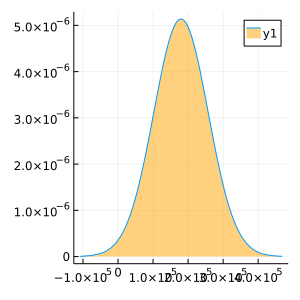

In [20]:
gr(size=(300,300))
plot(ŷ[1], fill=(0, .5,:orange))

For this model to predict the constant mean, we have to use the predict_mean method. 

With predict mean we do not get the distrution's standard deviation but only the mean. 

In [11]:
ŷ_mean = predict_mean(cmach, rows=test) # On the test set
ŷ_mean[1:3] |> pprint

[179752.7065750736, 179752.7065750736, 179752.7065750736]

As expected, the predicted values is the mean of the normal distribution for all input elements. 

With our mean predictions, we can calculate a loss

In [12]:
rms(ŷ_mean, y[test])

74431.17965544928

Let's see if we can reduce that error!

## KNN and Linear regression with l2 reg

Now we can use some algorithms. We will use a k nearest neighbor regressor as well as a linear regression with regularization. 

The nice thing ith MLJ is that when I say we will use 2 models, I do not mean separately, but together. In fact, we will perform a simple stacking of the two algorithms. 

In addition to this, we will also One hot encode the categorical variables and take the log of the target. 



In [23]:
RidgeRegressor = @load RidgeRegressor pkg="MultivariateStats"
KNNRegressor = @load KNNRegressor

import MLJMultivariateStatsInterface ✔
import NearestNeighborModels ✔

┌ Info: For silent loading, specify `verbosity=0`. 
└ @ Main /root/.julia/packages/MLJModels/5itei/src/loading.jl:168
┌ Info: For silent loading, specify `verbosity=0`. 
└ @ Main /root/.julia/packages/MLJModels/5itei/src/loading.jl:168


NearestNeighborModels.KNNRegressor

If we see the schema of the data. We can quickly know which columns would have to be tranformed. 

In [40]:
schema(X)

┌──────────────┬──────────────────────────────────┬───────────────────┐
│ _.names      │ _.types                          │ _.scitypes        │
├──────────────┼──────────────────────────────────┼───────────────────┤
│ OverallQual  │ CategoricalValue{Int64, UInt32}  │ OrderedFactor{10} │
│ GrLivArea    │ Float64                          │ Continuous        │
│ Neighborhood │ CategoricalValue{String, UInt32} │ Multiclass{25}    │
│ x1stFlrSF    │ Float64                          │ Continuous        │
│ TotalBsmtSF  │ Float64                          │ Continuous        │
│ BsmtFinSF1   │ Float64                          │ Continuous        │
│ LotArea      │ Float64                          │ Continuous        │
│ GarageCars   │ Int64                            │ Count             │
│ MSSubClass   │ CategoricalValue{String, UInt32} │ Multiclass{15}    │
│ GarageArea   │ Float64                          │ Continuous        │
│ YearRemodAdd │ Int64                            │ Count       

From schema(), we see that 3 columns will have to be transformed. 

Those are: 
- OverallQual
- Neighborhood 
- MSSubClass   

In [24]:
Xs = source(X)


Source @437 ⏎ `Table{Union{AbstractVector{Continuous}, AbstractVector{Count}, AbstractVector{Multiclass{25}}, AbstractVector{Multiclass{15}}, AbstractVector{OrderedFactor{10}}}}`

The source seems to partition the data into the different classes it has. 

As we saw by schema, we have 4 classes in our DF, hence, source has an Union of 4 classes. 

Altough, the cardinality of a categorical column creates an unique class (Multiclass{25}, Multiclass{15})

In [27]:
ys= source(y)

Source @286 ⏎ `AbstractVector{Continuous}`

In [33]:
hot = machine(OneHotEncoder(), Xs) # a hot one encoder machine  applied to the source Xs

W = transform(hot, Xs)
z = log(ys);

This kind of ressembles a workflow in R's tidymodels. 
Hot machine is applied to source 437 which is the X. Log transorm is applied to source 286 which is y. 

In [63]:
W

Node{Machine{OneHotEncoder,…}} @323
  args:
    1:	Source @437
  formula:
    transform(
        Machine{OneHotEncoder,…} @826, 
        Source @437)

In [64]:
z

Node{Nothing} @349
  args:
    1:	Source @286
  formula:
    #125(
        Source @286)

In [70]:
# Now we define some models and its parameters
ridge = machine(RidgeRegressor(lambda=2.5), W, z) # => ridge machinne 
knn   = machine(KNNRegressor(K=5), W, z) # we create a machine to hold the params. => Knn machine 

# We create predictions calling predict 
ẑ₁ = predict(ridge, W) # for now nodes are separated.
ẑ₂ = predict(knn, W)

Node{Machine{KNNRegressor,…}} @355
  args:
    1:	Node{Machine{OneHotEncoder,…}} @323
  formula:
    predict(
        Machine{KNNRegressor,…} @131, 
        transform(
            Machine{OneHotEncoder,…} @826, 
            Source @437))

We know combine the predictions of both models doing a simple addition ! 

In [71]:
ẑ = 0.3ẑ₁ + 0.7ẑ₂ # Here we make a linear combination of both predictions.

Node{Nothing} @557
  args:
    1:	Node{Nothing} @598
    2:	Node{Nothing} @913
  formula:
    +(
        #129(
            predict(
                Machine{RidgeRegressor,…} @301, 
                transform(
                    Machine{OneHotEncoder,…} @826, 
                    Source @437))),
        #129(
            predict(
                Machine{KNNRegressor,…} @131, 
                transform(
                    Machine{OneHotEncoder,…} @826, 
                    Source @437))))

Now ẑ is an stacked model of the KNN and the Ridge regressors. ẑ is composed by 30 % of ẑ₁ (Ridge's prediction) and 70% of ẑ₂ (Knn's prediction).

Our stacked model gives a higher weight to the knn regressor. 

Lastly y has to be exponentiated because we took the log of the target. 

In [73]:
ŷ = exp(ẑ)

Node{Nothing} @070
  args:
    1:	Node{Nothing} @557
  formula:
    #127(
        +(
            #129(
                predict(
                    Machine{RidgeRegressor,…} @301, 
                    transform(
                        Machine{OneHotEncoder,…} @826, 
                        Source @437))),
            #129(
                predict(
                    Machine{KNNRegressor,…} @131, 
                    transform(
                        Machine{OneHotEncoder,…} @826, 
                        Source @437)))))

Now we can train our model: 

ŷ is our workflow, the machine that holds the transformations in order. 

In [92]:
fit!(ŷ, rows=train) # will modify inplace ŷ. y
ypreds = ŷ(rows=test) # we get the predictions calling directly ŷ. 

print("trained")

trained

┌ Info: Not retraining Machine{OneHotEncoder,…} @826. Use `force=true` to force.
└ @ MLJBase /root/.julia/packages/MLJBase/De8Dv/src/machines.jl:357
┌ Info: Not retraining Machine{RidgeRegressor,…} @301. Use `force=true` to force.
└ @ MLJBase /root/.julia/packages/MLJBase/De8Dv/src/machines.jl:357
┌ Info: Not retraining Machine{KNNRegressor,…} @131. Use `force=true` to force.
└ @ MLJBase /root/.julia/packages/MLJBase/De8Dv/src/machines.jl:357


The Root mean squared error is now at 36435. It is less than half of the constant's loss. Clearly the model learned something. 

In [76]:
rms(y[test], ypreds)

36435.24190074054


### Does the stacking even improve our results ? 

We can fit them one by one and check it's error. 

A nice feature I found is that we don't have to rebuild everything. We can continue our worflow definition the moment before the stacking. 

Doing so, ẑ₁ is still the prediciton of the ridge regressor, the same goes for ẑ₂ which are the predictions of the KNN regressor. 

The difference is that now we do not combine the predictions. This results in two models, each of them with its own predictions. With these predictions we calculate the loss. 

In [98]:
# Exponentiate the predictions one by one. 
ŷ_1 = exp(ẑ₁) # machines are already specified until this point
ŷ_2 = exp(ẑ₂)

# Ridge fitted
fit!(ŷ_1, rows=train)
y_1_preds = ŷ_1(rows=test) 

# KNN fitted
fit!(ŷ_2, rows=train)
y_2_preds = ŷ_2(rows=test) 
 
print("trained \n")

trained 


┌ Info: Not retraining Machine{OneHotEncoder,…} @138. Use `force=true` to force.
└ @ MLJBase /root/.julia/packages/MLJBase/De8Dv/src/machines.jl:357
┌ Info: Not retraining Machine{RidgeRegressor,…} @411. Use `force=true` to force.
└ @ MLJBase /root/.julia/packages/MLJBase/De8Dv/src/machines.jl:357
┌ Info: Not retraining Machine{OneHotEncoder,…} @826. Use `force=true` to force.
└ @ MLJBase /root/.julia/packages/MLJBase/De8Dv/src/machines.jl:357
┌ Info: Not retraining Machine{KNNRegressor,…} @683. Use `force=true` to force.
└ @ MLJBase /root/.julia/packages/MLJBase/De8Dv/src/machines.jl:357


In [84]:
# RIDGE LOSS CALCULATED 
print("RIDGE LOSS: \n")
rms(y[test],y_1_preds )

RIDGE LOSS: 


23801.6273543209

In [85]:
print("KNN LOSS: \n")
rms(y[test],y_2_preds)

KNN LOSS: 


46134.08868874563

The ridge regression perform worst than the linear regression. Since our linear combinations gives more weigth to the knn's predictions, the loss is higher than the ridge's loss. 

**We can even review our stacking combination**:
 
Continue development at the point just before the stacking (as we just did). We create a new z prediciton value that is the linear combination of the predicitons of both models. The difference between ẑ_higher_ridge_weigth and ẑ is that we inversed the weigths, **now we give more weigth to the Ridge regressor (70% of ẑ₁)**

In [87]:
ẑ_higher_ridge_weigth = 0.7ẑ₁ + 0.3ẑ₂ # Here we make a linear combination of both predictions.

# Exponentiate the predictions one by one. 
ŷ_higher_ridge_weigth = exp(ẑ_higher_ridge_weigth) # machines are already specified until this point

# Ridge fitted
fit!(ŷ_higher_ridge_weigth, rows=train)
ŷ_higher_ridge_weigth_preds = ŷ_higher_ridge_weigth(rows=test) 


LOSS STACK WITH HIGHER WEIGTH FOR RIDGE: 


┌ Info: Not retraining Machine{OneHotEncoder,…} @826. Use `force=true` to force.
└ @ MLJBase /root/.julia/packages/MLJBase/De8Dv/src/machines.jl:357
┌ Info: Not retraining Machine{RidgeRegressor,…} @814. Use `force=true` to force.
└ @ MLJBase /root/.julia/packages/MLJBase/De8Dv/src/machines.jl:357
┌ Info: Not retraining Machine{KNNRegressor,…} @683. Use `force=true` to force.
└ @ MLJBase /root/.julia/packages/MLJBase/De8Dv/src/machines.jl:357


26573.498229072895

In [99]:
print("LOSS STACK WITH HIGHER WEIGTH FOR RIDGE: \n")
rms(y[test],ŷ_higher_ridge_weigth_preds)

LOSS STACK WITH HIGHER WEIGTH FOR RIDGE: 


26573.498229072895

Our stacked error is still higher than the single model error that the ridge regressor yielded. 

For now, the ridge regression is the best out of all the models and combinations we tried. 

In the next notebook we will try parameter tuning and see whether this change our results. In any case, stacking will make sense if models get specialized in specific predictions (if the errors are independent, we could say that they predict based on different parameters or detect different patterns or relations in the data). 